In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

import time
import datetime

import pickle

# Next two imports only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022

with open('data/model_scoring_dict.pickle', 'rb') as f:
    model_scoring_dict = pickle.load(f)

with open('data/models_dict.pickle', 'rb') as f:
    models_dict = pickle.load(f)

In [2]:
# Use this cell to reset the model dictionaries
#model_scoring_dict = {}
#models_dict = {}

### Importing the data

Because this dataset is part of a competition and a train-test split has already been performed, we'll treat the training data as the entire dataset. That way, we can perform our own train-test split, and, subsequently, we'll be able to acquire test scores of our own without necessarily having to submit to the competition. However, if at any point we're satisfied with a model, we can use that model to make predictions on the competition's original test data and submit those predictions to the competition if we so wish. As such, we'll import the competition's testing data as 'y_test_comp'.

We'll also combine our X and y into a single dataframe in case we need it for EDA, graphs, cleaning or the like.

In [4]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

X_test_comp = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

We'll first check to see if the classes are imbalanced.

In [5]:
print(y['h1n1_vaccine'].value_counts())
print(y['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


It looks as though the seasonal vaccine classes are very balanced, while the H1N1 vaccine classes are less so, with the minority class comprising about 20% of the samples. This is not necessarily a huge problem, so we won't do anything about it right this second, but we may revisit the issue after we get a first rough model built.

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [7]:
X.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


### To Pipeline? Or not to Pipeline?

For now, while exploring and experimenting with the data, we'll do things manually. Once we've settled on some models and cleaning strategies, we'll refactor the code into a pipeline.

# First Model: Basic Logistic Regression

To begin, we'll fit a basic logistic regression to the data. The only thing we'll do to prepare the data is to impute missing values (since most categories, including the numeric ones, are categorical, we'll go with the mode), one-hot encode the non-numeric columns, and scale the numeric columns. But first, a train-test split!

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [9]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

## Preprocessing

In [10]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)

### Simple Imputer

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [12]:
X_train_obj = X_train_imp[obj_columns]
X_test_obj = X_test_imp[obj_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

In [13]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [14]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

log_reg_h1n1.fit(X_train_scaled, y_train_h1n1)
log_reg_ssnl.fit(X_train_scaled, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [15]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_scaled)
y_hat_ssnl = log_reg_ssnl.predict(X_test_scaled)

In [16]:
y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_scaled)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_scaled)

In [17]:
cf_matrix_h1n1 = confusion_matrix(y_test_h1n1, y_hat_h1n1)
cf_matrix_ssnl = confusion_matrix(y_test_ssnl, y_hat_ssnl)

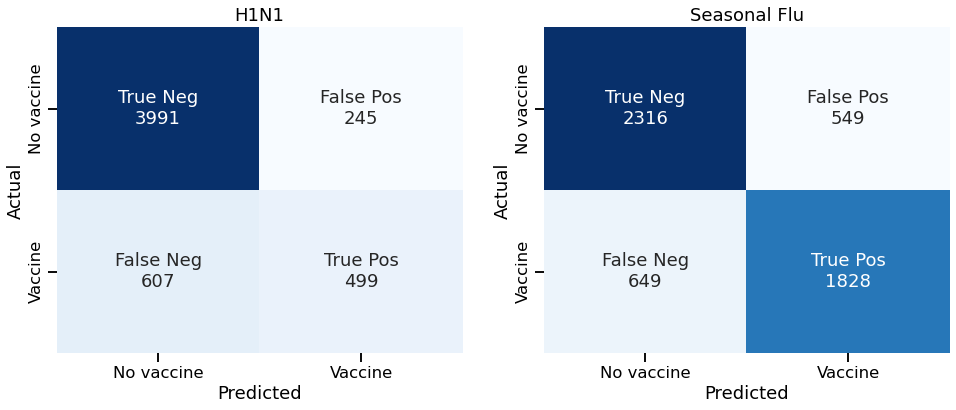

In [18]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['No vaccine', 'Vaccine']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix_h1n1.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

group_counts_2 = ['{0:0.0f}'.format(value) for value in cf_matrix_ssnl.flatten()]
labels_2 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_2)]
labels_2 = np.asarray(labels_2).reshape(2,2)

sns.set_context('talk')
fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

sns.heatmap(cf_matrix_h1n1, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax1)
ax1.set_ylabel('Actual')
ax1.set_yticklabels(ax1.get_yticklabels(), va="center")
ax1.set_xlabel('Predicted')
ax1.set_title('H1N1')

sns.heatmap(cf_matrix_ssnl, annot=labels_2, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax2)
ax2.set_ylabel('Actual')
ax2.set_yticklabels(ax2.get_yticklabels(), va="center")
ax2.set_xlabel('Predicted')
ax2.set_title('Seasonal Flu');

In [19]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1[:,1])}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_proba_ssnl[:,1])}')

Recall for H1N1:            0.4511754068716094
Recall for seasonal flu:    0.7379895034315704

Precision for H1N1:         0.6706989247311828
Precision for seasonal flu: 0.769036600757257

Accuracy for H1N1:          0.8405091725945338
Accuracy for seasonal flu:  0.775739423436915

F1 score for H1N1:          0.5394594594594594
F1 score for seasonal flu:  0.753193242686444

AUROC for H1N1:             0.8396438774168541
AUROC for seasonal flu:     0.8492191688842763


# Refactor into a pipeline

Now that we've got a basic and working but still fairly rough model with our cleaning steps mostly sorted out, we'll build a pipeline. We'll also code some of our graphing and scoring steps as a function so we can easily spit out several metrics for each model.

We'll also first redo our train-test split with with stratify because the H1N1-vaccinated class is slightly imbalanced. It likely won't be a drastic improvement, but we may be able to squeeze a small amount of extra juice out of any models going forward.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y['h1n1_vaccine'], random_state=random_state)

In [51]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl = y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl = y_test.iloc[:,1]

In [52]:
# Without this cell, a number of future cells will produce a SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()
y_train_h1n1 = y_train_h1n1.copy()
y_train_ssnl = y_train_ssnl.copy()
y_test_h1n1 = y_test_h1n1.copy()
y_test_ssnl = y_test_ssnl.copy()

In [53]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)
all_columns = list(X_train.columns.values)

### Two preprocessors, one for tree-based models, one for anything else

On closer inspection of the data, it's clear that the entire dataset is actually categorical. As such, our logistic regression would likely benefit from the whole dataset being one-hot encoded. On the other hand, tree-based models won't necessarily benefit from one-hot encoding, and a good deal of the categorical data is ordinal, which would benefit from scaling.

So one preprocessor will impute missing values and then one-hot encode every feature. The other processor will impute missing values, encode certain ordinal categories as numerical, and then min-max scale all ordinal features.

### The common pipeline

The pipelines can become somewhat complicated when attempting to run multiple imputers on different sets of columns. Because of this, we'll make a custom imputer function specifically for this dataset that runs before things feed into the pipeline. This is all necessary because three of our columns have nearly half of their values missing. It seems not quite right to replace them with the mode or median (like we'll do with the rest of the columns), but we also certainly don't want to be dropping ten-thousand datapoints. So for those we'll impute their missing values by hand with 'unknown', or in the case of health_insuarance, which is binary, with 2 (which will act more or less like 'unknown'). 

We'll also ordinally encode certain columns by hand (age_group, education, and income_poverty) for similar reasons. 

In [24]:
def impute_unk(df):
    df.loc[df['employment_industry'].isna(), 'employment_industry'] = 'unknown'
    df.loc[df['employment_occupation'].isna(), 'employment_occupation'] = 'unknown'
    df.loc[df['health_insurance'].isna(), 'health_insurance'] = 2
    
    for column in df:
        if df[column].isnull().any():
            df[column]=df[column].fillna(df[column].mode()[0])

In [25]:
def ord_encode(df):
    
    """
    This function takes a dataframe and encodes some of the
    categorical variables as ordinal, according to a pre-defined
    list of values. This operation is in place.
    """

    df = pd.DataFrame(df)
    
    age_group_values = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
    education_values = ['< 12 Years', '12 Years', 'Some College', 'College Graduate']
    income_poverty_values = ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']

    values_dict = {'age_group': age_group_values, 'education': education_values, 'income_poverty': income_poverty_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [26]:
def clean(df):
    impute_unk(df)
    ord_encode(df)

### Pipelines made easy

In order to run loads of models more quickly and conveniently, we'll put our pipeline into a function that takes an estimator and a choice of preprocessor and then fits the model, produces predictions, and then scores the model by passing those predictions to another scoring and graphing function.

In [27]:
def train_new_model(estimator, preprocessor, grid=None, model_name=['H1N1', 'Seasonal Flu'], keep_score=False, suppress_output=False):
    """
    This function takes in a tuned estimator as well as a choice of a preprocessor
    and returns a number of scoring metrics. It also saves the model and it's
    results in a scoring dictionary. It can alternatively do a grid search if passed
    a grid list. Scoring output can be suppressed with suppress_output=True.
    
    Note: The grid search feature is not yet functional.
    
    estimator: the class of the regressor or classifier to be modeled. Any desired
    hyperparameters should be included (e.g. LogisticRegression(max_iter=1000)).
    
    preprocessor: string - 'linear' or 'tree'
    
    grid: a list of hyperparameters with which do do a grid search
    
    suppress_output: bool
    """
    
    ohe_transform = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])
        
    linear_preprocessor = Pipeline(
        steps=[
            ('ohe', ohe_transform),
            ('est', estimator)
        ])
        
    tree_transformer = ColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), numeric_columns),
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
        ])
        
    tree_preprocessor = Pipeline(
        steps=[
            ('tree', tree_transformer),
            ('est', estimator)
        ])
    
    if grid:
        pass
    
    else:
        
        global models_dict
        
        if preprocessor == 'linear':
            pipe = linear_preprocessor
        elif preprocessor == 'tree':
            pipe = tree_preprocessor
        
        def create_entry(i):
            
            dictionary_entry = {'estimator': None, 
                                'preprocessor': None, 
                                'fitted_estimator': None, 
                                'scores': None,
                                'predictions': None,
                                'time_run': None
                               }
            
            dictionary_entry['estimator'] = estimator
            dictionary_entry['preprocessor'] = preprocessor
            dictionary_entry['fitted_estimator'] = fitted_estimator
            dictionary_entry['predictions'] = [y_hat, y_proba, y_proba_comp]
            dictionary_entry['time_run'] = time.asctime()
            models_dict[model_name[i]] = dictionary_entry
        
        clean(X_train)
        clean(X_test)
        clean(X_test_comp)
        
        fitted_estimator = pipe.fit(X_train, y_train_h1n1)
        y_hat = pipe.predict(X_test)
        y_hat_h1n1 = y_hat
        y_proba = pipe.predict_proba(X_test)
        y_proba_h1n1 = y_proba
        y_proba_comp = pipe.predict_proba(X_test_comp)
        y_proba_h1n1_comp = y_proba_comp
        
        if keep_score:
            create_entry(0)

        fitted_estimator = pipe.fit(X_train, y_train_ssnl)
        y_hat = pipe.predict(X_test)
        y_hat_ssnl = y_hat
        y_proba = pipe.predict_proba(X_test)
        y_proba_ssnl = y_proba
        y_proba_comp = pipe.predict_proba(X_test_comp)
        y_proba_ssnl_comp = y_proba_comp
        
        if keep_score:
            create_entry(1)
            
        all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=model_name, keep_score=keep_score, suppress_output=suppress_output)

### And a nice big function to score them

This function will take in lists of target data and lists of predictions and probabilities and return a number of scoring metrics as well as print out confusion matrices for quick and easy comprehension.

In [28]:
def all_metrics(y_actuals, y_hats, y_score=None, model_name=None, keep_score=False, save_fig=False, suppress_output=False):
    """
    This function takes in y data either as single dataframes or in groups
    as lists and returns recall, precision, accuracy, and f1 score. 
    If y_score is provided, an AUC score will also be calculated.
    If a name for the model is supplied and keep_score is set to True,
    that name along with scores are stored in a model dictionary for later use. 
    
    y_actuals: array/dataframe or a list of arrays/dataframes
    
    y_hats: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    y_score: if y_actuals is list, then list of same length. if 
    y_actuals is single array/dataframe, then single array/dataframe.
    
    model_name: string or list of strings. If y_actuals is 
    single array/dataframe, then string. If y_actuals is list, then
    list of same length.
    
    keep_score: bool, saves scores in a score dictionary
    
    save_fig: bool, exports graph to graph folder
    
    suppress_output, bool, if True, scores the model and can additionally
    save scores but does not output any graphs or scoring metrics
    
    Note: save_fig is only supported for single models.
    
    """
    global model_scoring_dict
    global models_dict

    if type(y_actuals) == list:
        if len(y_actuals) != len(y_hats):
            print('The size of each list for y_tests and y_hats needs to be the same size.')
            return
        elif model_name and len(y_actuals) != len(model_name):
            print('The number of names does not match the number of models.')
            return
        else:
            all_scores = {}
            confusion_matrices = []
            for i in list(range(len(y_actuals))):
                y_actual = y_actuals[i]
                y_hat = y_hats[i]
                model_scores = {}
                cf_matrix = confusion_matrix(y_actual, y_hat)
                model_scores['recall'] = recall_score(y_actual, y_hat)
                model_scores['precision'] = precision_score(y_actual, y_hat)
                model_scores['accuracy'] = accuracy_score(y_actual, y_hat)
                model_scores['f1'] = f1_score(y_actual, y_hat)
                if y_score:
                    model_scores['AUC'] = roc_auc_score(y_actual, y_score[i][:,1])
                
                if model_name:
                    all_scores[model_name[i]] = model_scores
                    if keep_score:
                        model_scoring_dict[model_name[i]] = model_scores
                        
                        if model_name[i] not in models_dict:
                            models_dict[model_name[i]] = {}
                        
                        models_dict[model_name[i]]['scores'] = model_scoring_dict[model_name[i]]
            
                else:
                    all_scores[f'model number {i+1}'] = model_scores
                    
                confusion_matrices.append(cf_matrix)
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        row = len(all_scores) // 3
        col = len(all_scores) % 3
        
        if len(all_scores) < 4:
            ncols=len(all_scores)
            nrows=1
        else:
            ncols=3
            if col != 0:
                nrows=row+1
            else:
                nrows=row
                
        sns.set_context('talk')
        fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
        
        for i, model in zip(range(len(all_scores)), all_scores):
            group_names = ['True Neg','False Pos','False Neg','True Pos']
            categories = ['No vaccine', 'Vaccine']

            group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrices[i].flatten()]
            labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
            labels = np.asarray(labels).reshape(2,2)

            row = i // 3
            col = i % 3
            
            if nrows < 2:
                ax = axes[col]
            else:
                ax = axes[row][col]
            sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
            ax.set_ylabel('Actual')
            ax.set_yticklabels(ax.get_yticklabels(), va="center")
            ax.set_xlabel('Predicted')
        
            if model_name:
                ax.set_title(model_name[i])
            else:
                ax.set_title('Model Performance')
                
        plt.tight_layout()        

        
        for model in all_scores:
            print('Recall for {}:    {}'.format(model, all_scores[model]['recall']))
        print('')
        for model in all_scores:
            print('Precision for {}: {}'.format(model, all_scores[model]['precision']))
        print('')
        for model in all_scores:
            print('Accuracy for {}:  {}'.format(model, all_scores[model]['accuracy']))
        print('')
        for model in all_scores:
            print('F1 score for {}:  {}'.format(model, all_scores[model]['f1']))
        if y_score:
            print('')
            for model in all_scores:
                print('AUROC for {}:     {}'.format(model, all_scores[model]['AUC']))
            
    else:
        if model_name and type(model_name) != str:
            print('There should only be one model name, and it should be a string.')
            return
        else:
            all_scores = {}
            model_scores = {}
            cf_matrix = confusion_matrix(y_actuals, y_hats)
            model_scores['recall'] = recall_score(y_actuals, y_hats)
            model_scores['precision'] = precision_score(y_actuals, y_hats)
            model_scores['accuracy'] = accuracy_score(y_actuals, y_hats)
            model_scores['f1'] = f1_score(y_actuals, y_hats)
            if y_score is not None:
                model_scores['AUC'] = roc_auc_score(y_actuals, y_score[:,1])
                
            if model_name:
                if keep_score:
                    model_scoring_dict[model_name] = model_scores
                    models_dict[model_name]['scores'] = model_scoring_dict[model_name]

            else:
                all_scores['model'] = model_scores
        
        if keep_score:
            competition_score_csv()
            
            with open('data/models_dict.pickle', 'wb') as f:
                pickle.dump(models_dict, f)
            with open('data/model_scoring_dict.pickle', 'wb') as f:
                pickle.dump(model_scoring_dict, f)
        
        if suppress_output:
            return
        
        cf_matrix = confusion_matrix(y_actuals, y_hats)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        categories = ['No vaccine', 'Vaccine']

        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)

        sns.set_context('talk')
        fig, ax = plt.subplots(figsize=(8,6))

        sns.heatmap(cf_matrix, annot=labels, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
        ax.set_ylabel('Actual')
        ax.set_yticklabels(ax.get_yticklabels(), va="center")
        ax.set_xlabel('Predicted')
        if model_name:
            ax.set_title(model_name)
        else:
            ax.set_title('Model Performance')
        
        if save_fig:
            fig.savefig('./graphs/{}'.format(model_name if model_name else 'rename_me'), dpi=300, transparent=False, bbox_inches='tight');
        
        print('Recall:    {}'.format(model_scores['recall']))
        print('Precision: {}'.format(model_scores['precision']))
        print('Accuracy:  {}'.format(model_scores['accuracy']))
        print('F1 score:  {}'.format(model_scores['f1']))
        if y_score is not None:
            print('AUROC:     {}'.format(model_scores['AUC']))

And one more little function to create a file for submission to the competition.

In [29]:
def competition_score_csv():
    
    now = datetime.datetime.now()

    date_time_string = str(now.month) + str(now.day) + str(now.year) + str(now.hour) + str(now.minute) + str(now.second)
    
    submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")
    
    if np.testing.assert_array_equal(X_test_comp.index.values, submission_df.index.values) == False:
        return
    
    submission_df["h1n1_vaccine"] = y_proba_h1n1_comp[:, 1]
    submission_df["seasonal_vaccine"] = y_proba_ssnl_comp[:, 1]
    
    submission_df.to_csv(f'data/comp_submissions/my_submission{date_time_string}.csv', index=True)
    
    return submission_df.head()

And, lastly, a function to return just the y_preds for a given model that's already been fitted. We could have built this and the last function into our larger model training or model scoring functions, but they were getting large and unwieldy, and would be hard to diagnose if bugs were to arise.

In [30]:
def get_predictions(model_name):
    """
    This function takes in a model name, and returns the predictions and probabilities
    previously calculated for that model. This function can be indexed. 
    
    [0] returns y_hat
    [1] returns y_proba
    [2] returns y_proba_comp
    
    model_name: string, must match a model in models_dict
    """
    
    return models_dict[model_name]['predictions']

So now that the pipeline and scoring code is done, we can start throwing models at it, and since we've build a dictionary to hold the models into our function, that will be a nice way to keep track of our progress. Now on to the modeling!

# Models galore!

Recall for Simple Logistic - H1N1:    0.5004405286343613
Recall for Simple Logistic - SSNL:    0.7442424242424243

Precision for Simple Logistic - H1N1: 0.7244897959183674
Precision for Simple Logistic - SSNL: 0.76814011676397

Accuracy for Simple Logistic - H1N1:  0.8534256832646949
Accuracy for Simple Logistic - SSNL:  0.7774241856982403

F1 score for Simple Logistic - H1N1:  0.5919749869723814
F1 score for Simple Logistic - SSNL:  0.7560024625487379

AUROC for Simple Logistic - H1N1:     0.8691042514625823
AUROC for Simple Logistic - SSNL:     0.8564199370756748


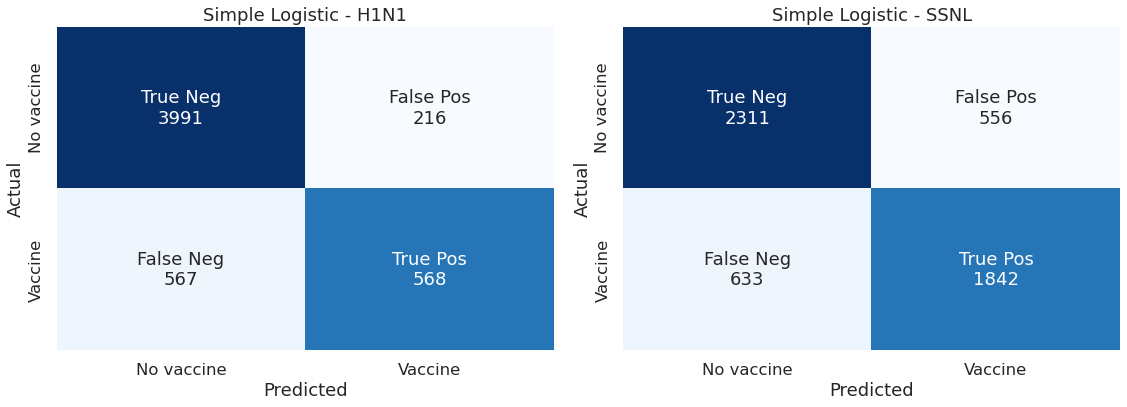

In [425]:
# Baseline Logistic Regression

train_new_model(LogisticRegression(max_iter=1000), 'linear', keep_score=True, model_name=['Simple Logistic - H1N1', 'Simple Logistic - SSNL'])

Recall for Untuned Naive Bayes - H1N1:    0.7295154185022027
Recall for Untuned Naive Bayes - SSNL:    0.7684848484848484

Precision for Untuned Naive Bayes - H1N1: 0.37894736842105264
Precision for Untuned Naive Bayes - SSNL: 0.6583592938733126

Accuracy for Untuned Naive Bayes - H1N1:  0.6885061774616249
Accuracy for Untuned Naive Bayes - SSNL:  0.7079745413702733

F1 score for Untuned Naive Bayes - H1N1:  0.4987951807228916
F1 score for Untuned Naive Bayes - SSNL:  0.70917225950783

AUROC for Untuned Naive Bayes - H1N1:     0.7618796656296565
AUROC for Untuned Naive Bayes - SSNL:     0.7826719937427994


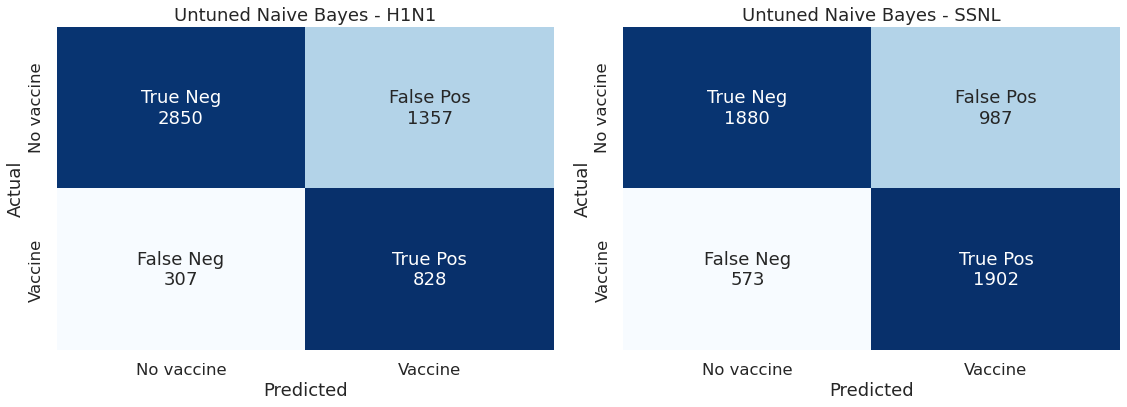

In [427]:
# Untuned Naive Bayes

train_new_model(GaussianNB(), 'linear', model_name=['Untuned Naive Bayes - H1N1', 'Untuned Naive Bayes - SSNL'], keep_score=True)

Recall for Tuned Naive Bayes - H1N1:    0.5744493392070484
Recall for Tuned Naive Bayes - SSNL:    0.7915151515151515

Precision for Tuned Naive Bayes - H1N1: 0.57243195785777
Precision for Tuned Naive Bayes - SSNL: 0.6941885187810064

Accuracy for Tuned Naive Bayes - H1N1:  0.8184200673904904
Accuracy for Tuned Naive Bayes - SSNL:  0.7418569824035942

F1 score for Tuned Naive Bayes - H1N1:  0.5734388742304309
F1 score for Tuned Naive Bayes - SSNL:  0.7396639607324902

AUROC for Tuned Naive Bayes - H1N1:     0.8285115325935691
AUROC for Tuned Naive Bayes - SSNL:     0.82314445466172


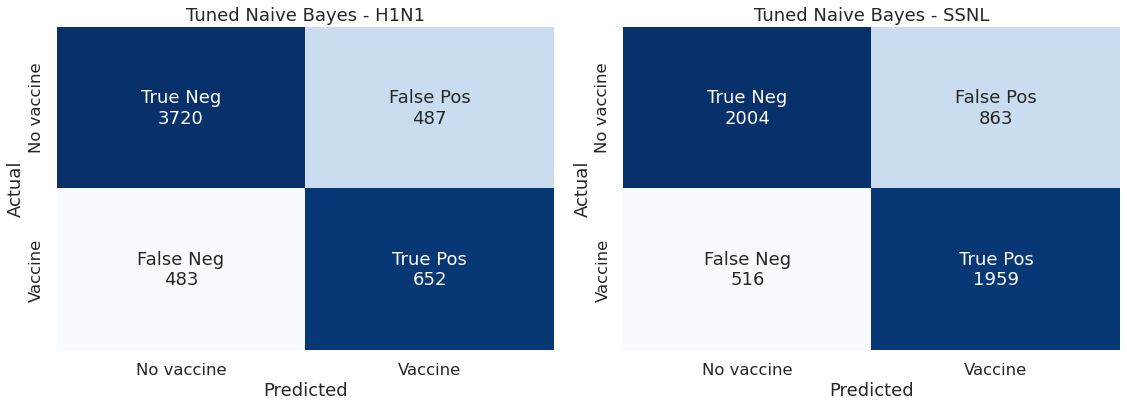

In [428]:
# Tuned Naive Bayes

train_new_model(GaussianNB(var_smoothing=1), 'linear', model_name=['Tuned Naive Bayes - H1N1', 'Tuned Naive Bayes - SSNL'], keep_score=True)

Recall for Untuned HistGradientBoost - H1N1:    0.5312775330396475
Recall for Untuned HistGradientBoost - SSNL:    0.7519191919191919

Precision for Untuned HistGradientBoost - H1N1: 0.7247596153846154
Precision for Untuned HistGradientBoost - SSNL: 0.7652138157894737

Accuracy for Untuned HistGradientBoost - H1N1:  0.8575439910146013
Accuracy for Untuned HistGradientBoost - SSNL:  0.778172968925496

F1 score for Untuned HistGradientBoost - H1N1:  0.6131164209456024
F1 score for Untuned HistGradientBoost - SSNL:  0.7585082535153862

AUROC for Untuned HistGradientBoost - H1N1:     0.8716343329609033
AUROC for Untuned HistGradientBoost - SSNL:     0.8578102616679526


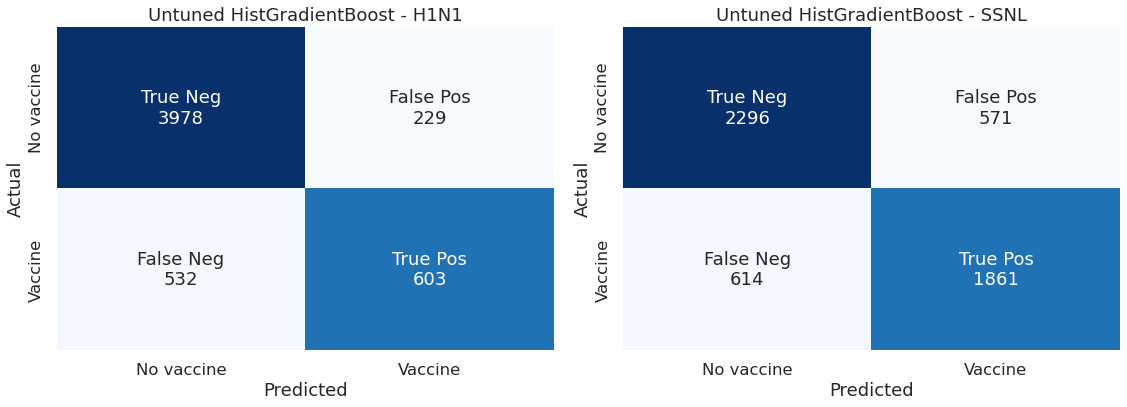

In [432]:
# Untuned HistGradientBoost

train_new_model(HistGradientBoostingClassifier(), 'tree', model_name=['Untuned HistGradientBoost - H1N1', 'Untuned HistGradientBoost - SSNL'], keep_score=True)

Recall for Tuned HistGradientBoost - H1N1:    0.5136563876651983
Recall for Tuned HistGradientBoost - SSNL:    0.7559595959595959

Precision for Tuned HistGradientBoost - H1N1: 0.7398477157360406
Precision for Tuned HistGradientBoost - SSNL: 0.7680623973727422

Accuracy for Tuned HistGradientBoost - H1N1:  0.858292774241857
Accuracy for Tuned HistGradientBoost - SSNL:  0.7811681018345189

F1 score for Tuned HistGradientBoost - H1N1:  0.6063442537701509
F1 score for Tuned HistGradientBoost - SSNL:  0.7619629403380167

AUROC for Tuned HistGradientBoost - H1N1:     0.8738435730673337
AUROC for Tuned HistGradientBoost - SSNL:     0.859960046929004


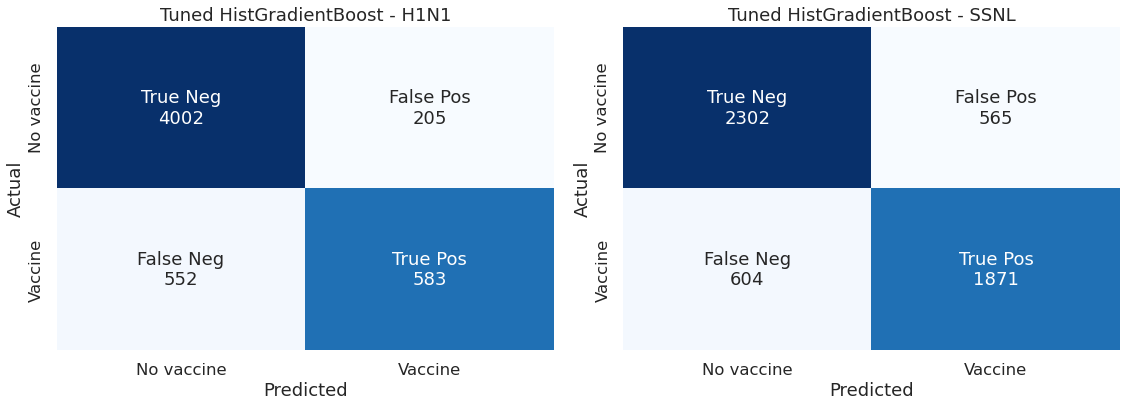

In [429]:
# Tuned HistGradientBoosting

train_new_model(HistGradientBoostingClassifier(learning_rate=0.1, max_depth=9, max_iter=70), 'tree', model_name=['Tuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - SSNL'], keep_score=True)

Recall for Untuned Random Forest - H1N1:    0.4220264317180617
Recall for Untuned Random Forest - SSNL:    0.7462626262626263

Precision for Untuned Random Forest - H1N1: 0.7664
Precision for Untuned Random Forest - SSNL: 0.767983367983368

Accuracy for Untuned Random Forest - H1N1:  0.8498689629352303
Accuracy for Untuned Random Forest - SSNL:  0.7779857731186821

F1 score for Untuned Random Forest - H1N1:  0.5443181818181818
F1 score for Untuned Random Forest - SSNL:  0.7569672131147541

AUROC for Untuned Random Forest - H1N1:     0.86190783349337
AUROC for Untuned Random Forest - SSNL:     0.8496434875437318


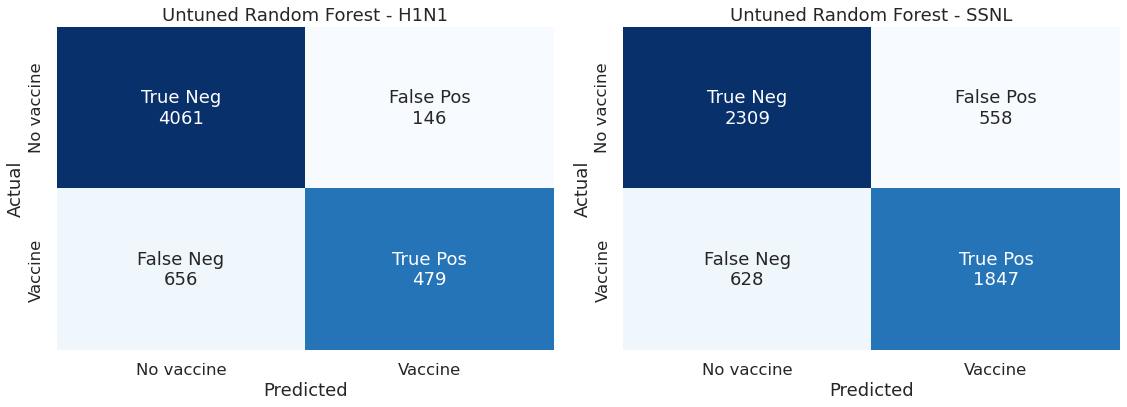

In [433]:
# Untuned Random Forest

train_new_model(RandomForestClassifier(), 'tree', model_name=['Untuned Random Forest - H1N1', 'Untuned Random Forest - SSNL'], keep_score=True)

Recall for Tuned Random Forest - H1N1:    0.4061674008810573
Recall for Tuned Random Forest - SSNL:    0.7369696969696969

Precision for Tuned Random Forest - H1N1: 0.7840136054421769
Precision for Tuned Random Forest - SSNL: 0.7660646787064259

Accuracy for Tuned Random Forest - H1N1:  0.8500561587420442
Accuracy for Tuned Random Forest - SSNL:  0.7738674653687757

F1 score for Tuned Random Forest - H1N1:  0.5351131746952988
F1 score for Tuned Random Forest - SSNL:  0.7512355848434925

AUROC for Tuned Random Forest - H1N1:     0.8635632452310968
AUROC for Tuned Random Forest - SSNL:     0.8503994954779747


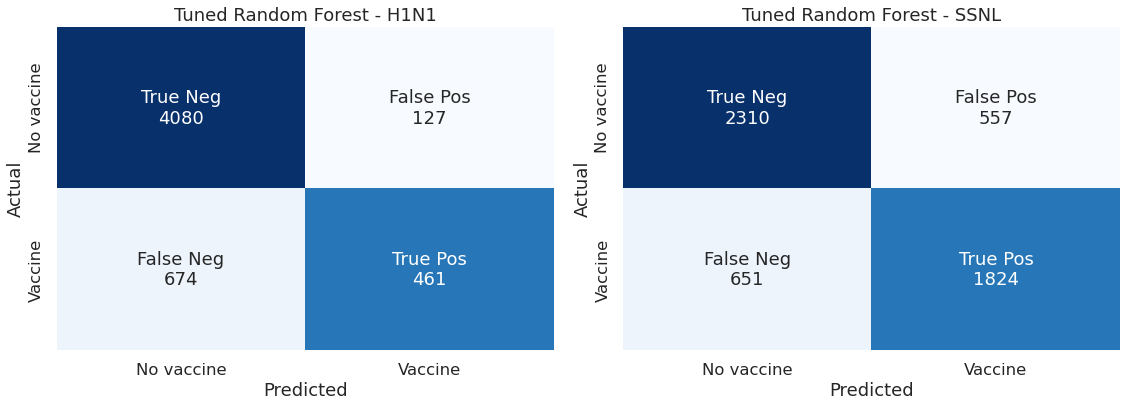

In [434]:
# Tuned Random Forest

train_new_model(RandomForestClassifier(criterion='gini', max_depth=20, min_samples_leaf=2, min_samples_split=4), 'tree', model_name=['Tuned Random Forest - H1N1', 'Tuned Random Forest - SSNL'], keep_score=True)

Recall for Untuned SVC - H1N1:    0.45374449339207046
Recall for Untuned SVC - SSNL:    0.7450505050505051

Precision for Untuned SVC - H1N1: 0.7756024096385542
Precision for Untuned SVC - SSNL: 0.7689741451209341

Accuracy for Untuned SVC - H1N1:  0.8560464245600898
Accuracy for Untuned SVC - SSNL:  0.778172968925496

F1 score for Untuned SVC - H1N1:  0.5725403001667593
F1 score for Untuned SVC - SSNL:  0.7568233121280525

AUROC for Untuned SVC - H1N1:     0.8602358770624583
AUROC for Untuned SVC - SSNL:     0.8547645270282174


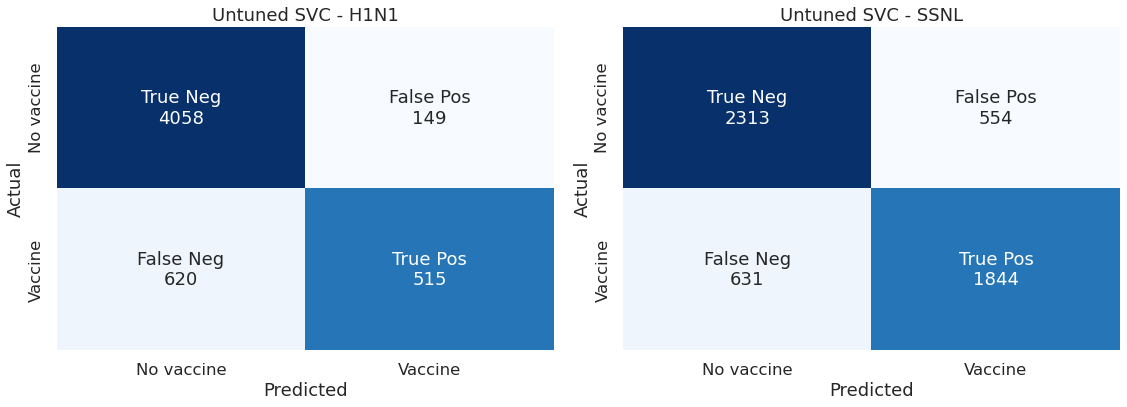

In [472]:
# Untuned SVC

train_new_model(SVC(probability=True), 'linear', model_name=['Untuned SVC - H1N1', 'Untuned SVC - SSNL'], keep_score=True)

Recall for Tuned SVC - H1N1:    0.4801762114537445
Recall for Tuned SVC - SSNL:    0.7442424242424243

Precision for Tuned SVC - H1N1: 0.7384823848238482
Precision for Tuned SVC - SSNL: 0.7723270440251573

Accuracy for Tuned SVC - H1N1:  0.8534256832646949
Accuracy for Tuned SVC - SSNL:  0.7798577311868214

F1 score for Tuned SVC - H1N1:  0.5819540843566471
F1 score for Tuned SVC - SSNL:  0.7580246913580246

AUROC for Tuned SVC - H1N1:     0.8664519696038383
AUROC for Tuned SVC - SSNL:     0.855779067268429


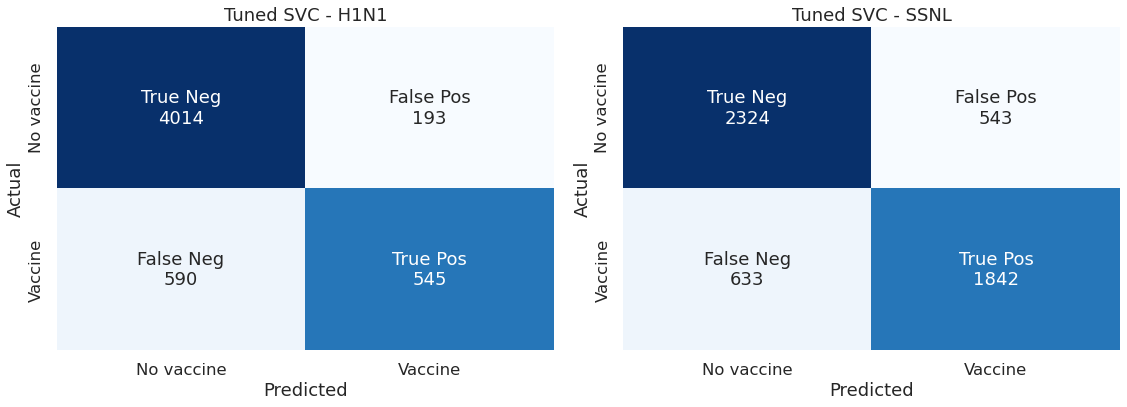

In [473]:
# Tuned SVC

train_new_model(SVC(probability = True, kernel='linear', C=1, gamma=0.001), 'linear', model_name=['Tuned SVC - H1N1', 'Tuned SVC - SSNL'], keep_score=True)

### One more model - competition baseline

This dataset is currently part of a competition on drivendata.org. The competition has conveniently provided their own baseline model on which participants can choose to improve if they so desire. We'll include it here so that we can gauge our progress by some external measure, but we'll need to train-test split and clean again, since their strategy was different from ours.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=random_state)

In [33]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

In [34]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)

In [35]:
X_train_reduced = X_train[numeric_columns]
X_test_reduced = X_test[numeric_columns]

In [36]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_reduced), columns=X_train_reduced.columns, index=X_train_reduced.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_reduced), columns=X_test_reduced.columns, index=X_test_reduced.index)

In [37]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(X_train_reduced)

X_train_imp = pd.DataFrame(imputer.transform(X_train_scaled), columns=X_train_scaled.columns, index=X_train_scaled.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test_scaled), columns=X_test_scaled.columns, index=X_test_scaled.index)

In [38]:
%%time

log_reg_h1n1 = LogisticRegression(penalty="l2", C=1)
log_reg_ssnl = LogisticRegression(penalty="l2", C=1)

log_reg_h1n1.fit(X_train_imp, y_train_h1n1)
log_reg_ssnl.fit(X_train_imp, y_train_ssnl);

CPU times: user 227 ms, sys: 133 ms, total: 360 ms
Wall time: 183 ms


LogisticRegression(C=1)

### Now we'll score it and plot a confusion matrix

In [39]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_imp)
y_hat_ssnl = log_reg_ssnl.predict(X_test_imp)

y_proba_h1n1 = log_reg_h1n1.predict_proba(X_test_imp)
y_proba_ssnl = log_reg_ssnl.predict_proba(X_test_imp)

Recall for Competition Baseline - H1N1:    0.4043803418803419
Recall for Competition Baseline - SSNL:    0.7151559454191033

Precision for Competition Baseline - H1N1: 0.6503436426116839
Precision for Competition Baseline - SSNL: 0.7458703939008895

Accuracy for Competition Baseline - H1N1:  0.8273201724529158
Accuracy for Competition Baseline - SSNL:  0.7539142273655548

F1 score for Competition Baseline - H1N1:  0.49868247694334655
F1 score for Competition Baseline - SSNL:  0.7301903221793755

AUROC for Competition Baseline - H1N1:     0.8206886901112268
AUROC for Competition Baseline - SSNL:     0.8223370964270786


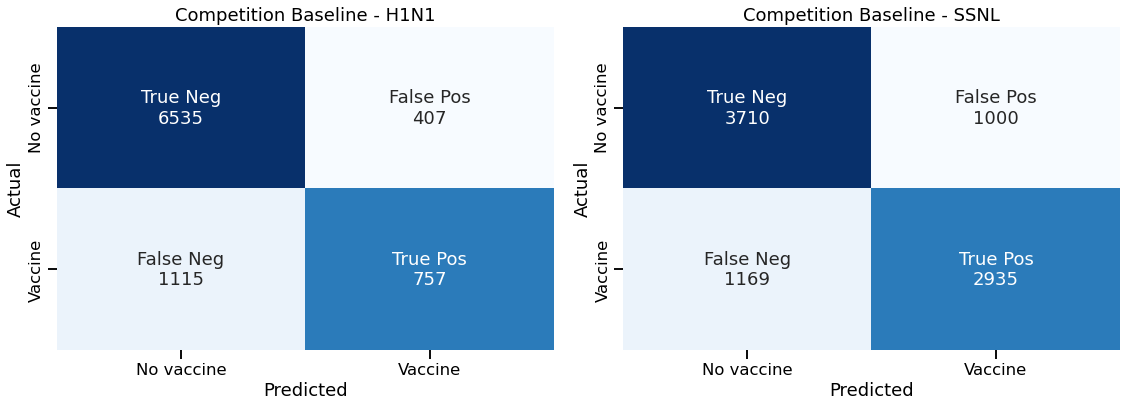

In [40]:
all_metrics([y_test_h1n1, y_test_ssnl], [y_hat_h1n1, y_hat_ssnl], [y_proba_h1n1, y_proba_ssnl], model_name=['Competition Baseline - H1N1', 'Competition Baseline - SSNL'], keep_score=True)

# THE SLIDE

It's always a good idea to see the progress of our models. We'll graph that progress for a select few. Since multiple people were running models simultaneously, it's not feasible to make a meaningful graph that shows models chronologically. Instead, we'll organize them in pairs (if we have pairs) of an untuned model with its tuned model, with the better-performing models to the right. We'll then use the same order for both H1N1 and the seasonal flu though, so the best model may not be the rightmost model.

In [31]:
list(models_dict.keys())

['Tuned SVC - H1N1',
 'Tuned SVC - SSNL',
 'Simple Logistic - H1N1',
 'Simple Logistic - SSNL',
 'Untuned SVC - H1N1',
 'Untuned SVC - SSNL',
 'Tuned HistGradientBoost - H1N1',
 'Tuned HistGradientBoost - SSNL',
 'Untuned HistGradientBoost - H1N1',
 'Untuned HistGradientBoost - SSNL',
 'Tuned Random Forest - H1N1',
 'Tuned Random Forest - SSNL',
 'Untuned Random Forest - H1N1',
 'Untuned Random Forest - SSNL',
 'Untuned Naive Bayes - H1N1',
 'Untuned Naive Bayes - SSNL',
 'Tuned Naive Bayes - H1N1',
 'Tuned Naive Bayes - SSNL',
 'Competition Baseline - H1N1',
 'Competition Baseline - SSNL']

In [32]:
h1n1_models_to_graph = ['Competition Baseline - H1N1', 'Untuned Naive Bayes - H1N1', 'Tuned Naive Bayes - H1N1', 'Simple Logistic - H1N1', 'Untuned HistGradientBoost - H1N1', 'Tuned HistGradientBoost - H1N1', 'Untuned Random Forest - H1N1', 'Tuned Random Forest - H1N1', 'Untuned SVC - H1N1', 'Tuned SVC - H1N1']
ssnl_models_to_graph = ['Competition Baseline - SSNL', 'Untuned Naive Bayes - SSNL', 'Tuned Naive Bayes - SSNL', 'Simple Logistic - SSNL', 'Untuned HistGradientBoost - SSNL', 'Tuned HistGradientBoost - SSNL', 'Untuned Random Forest - SSNL', 'Tuned Random Forest - SSNL', 'Untuned SVC - SSNL', 'Tuned SVC - SSNL']

In [33]:
h1n1_graph_data = []

for model in h1n1_models_to_graph:
    h1n1_graph_data.append((model, models_dict[model]['scores']['precision'], models_dict[model]['scores']['accuracy']))
    
ssnl_graph_data = []

for model in ssnl_models_to_graph:
    ssnl_graph_data.append((model, models_dict[model]['scores']['precision'], models_dict[model]['scores']['accuracy']))

In [34]:
ssnl_graph_data

[('Competition Baseline - SSNL', 0.7458703939008895, 0.7539142273655548),
 ('Untuned Naive Bayes - SSNL', 0.6583592938733126, 0.7079745413702733),
 ('Tuned Naive Bayes - SSNL', 0.6941885187810064, 0.7418569824035942),
 ('Simple Logistic - SSNL', 0.76814011676397, 0.7774241856982403),
 ('Untuned HistGradientBoost - SSNL', 0.7652138157894737, 0.778172968925496),
 ('Tuned HistGradientBoost - SSNL', 0.7680623973727422, 0.7811681018345189),
 ('Untuned Random Forest - SSNL', 0.767983367983368, 0.7779857731186821),
 ('Tuned Random Forest - SSNL', 0.7660646787064259, 0.7738674653687757),
 ('Untuned SVC - SSNL', 0.7689741451209341, 0.778172968925496),
 ('Tuned SVC - SSNL', 0.7723270440251573, 0.7798577311868214)]

In [35]:
h1n1_graph_data

[('Competition Baseline - H1N1', 0.6503436426116839, 0.8273201724529158),
 ('Untuned Naive Bayes - H1N1', 0.37894736842105264, 0.6885061774616249),
 ('Tuned Naive Bayes - H1N1', 0.57243195785777, 0.8184200673904904),
 ('Simple Logistic - H1N1', 0.7244897959183674, 0.8534256832646949),
 ('Untuned HistGradientBoost - H1N1', 0.7247596153846154, 0.8575439910146013),
 ('Tuned HistGradientBoost - H1N1', 0.7398477157360406, 0.858292774241857),
 ('Untuned Random Forest - H1N1', 0.7664, 0.8498689629352303),
 ('Tuned Random Forest - H1N1', 0.7840136054421769, 0.8500561587420442),
 ('Untuned SVC - H1N1', 0.7756024096385542, 0.8560464245600898),
 ('Tuned SVC - H1N1', 0.7384823848238482, 0.8534256832646949)]

In [36]:
h1n1_xticklabels = []
h1n1_y_pre = []
h1n1_y_acc = []

for model_name, model_pre, model_acc in h1n1_graph_data:
    h1n1_xticklabels.append(model_name)
    h1n1_y_pre.append(model_pre)
    h1n1_y_acc.append(model_acc)

ssnl_xticklabels = []
ssnl_y_pre = []
ssnl_y_acc = []

for model_name, model_pre, model_acc in ssnl_graph_data:
    ssnl_xticklabels.append(model_name)
    ssnl_y_pre.append(model_pre)
    ssnl_y_acc.append(model_acc)

In [37]:
xtickabbrev = ['Competition Baseline',
                    'Untuned Naive Bayes',
                    'Tuned Naive Bayes',
                    'Simple Logistic',
                    'Untuned HistGradientBoost',
                    'Tuned HistGradientBoost',
                    'Untuned Random Forest',
                    'Tuned Random Forest',
                    'Untuned SVC',
                    'Tuned SVC']

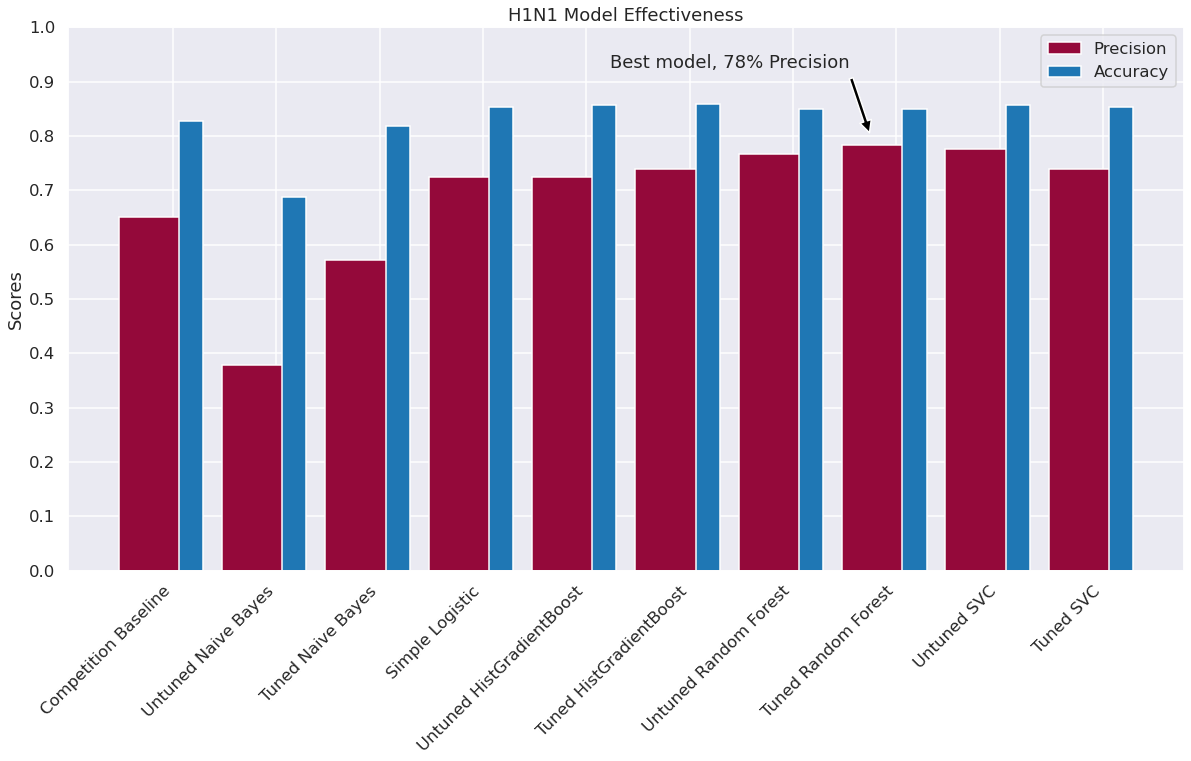

In [38]:
sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

width = .35

ax.bar(np.array(range(len(xtickabbrev))) - width/2, h1n1_y_pre, width*2, color='#94093a', label="Precision")
ax.bar(np.array(range(len(xtickabbrev))) + width/2, h1n1_y_acc, width/3*2, label="Accuracy")
ax.set(ylim=(0, 1))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xticks(list(range(len(xtickabbrev))))
ax.set_xticklabels(xtickabbrev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Scores')
ax.set_title('H1N1 Model Effectiveness')
ax.annotate('Best model, 78% Precision', xy=(6.75, .8),
            xytext=(0.7, .95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top'
            );
#fig.savefig('graphs/H1N1_models', dpi=300, transparent=True, bbox_inches='tight', pad_inches=1);

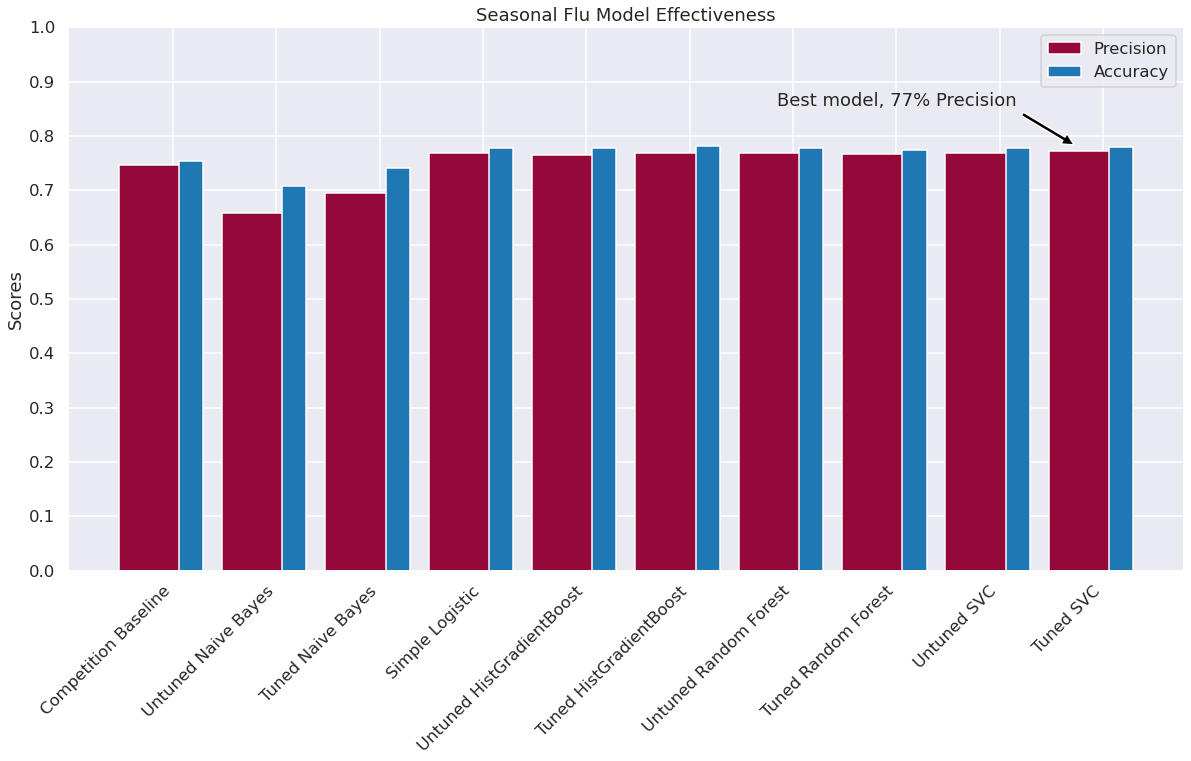

In [39]:
sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

width = .35

ax.bar(np.array(range(len(xtickabbrev))) - width/2, ssnl_y_pre, width*2, color='#94093a', label="Precision")
ax.bar(np.array(range(len(xtickabbrev))) + width/2, ssnl_y_acc, width/3*2, label="Accuracy")
ax.set(ylim=(0, 1))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xticks(list(range(len(xtickabbrev))))
ax.set_xticklabels(xtickabbrev)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend()

ax.set_ylabel('Scores')
ax.set_title('Seasonal Flu Model Effectiveness')
ax.annotate('Best model, 77% Precision', xy=(8.75, .78),
            xytext=(0.85, .88), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top'
            );
#fig.savefig('graphs/SSNL_models', dpi=300, transparent=False, bbox_inches='tight', pad_inches=1);

# Appendix 1: cleaning and pipelines by hand

Unfortunately, the sheer convenience of the several modeling functions in this notebook are tempered by their lack of flexibility. The more flexibility and features built in, the more unweildy they become and subsequently tend to be difficult to debug when something goes wrong. As such, this section of the notebook exists to facilitate easy and quick scratch work in the pipeline separate from the above functions. 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y['h1n1_vaccine'], random_state=random_state)

In [41]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl = y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl = y_test.iloc[:,1]

In [42]:
# Without this cell, a number of future cells will produce a SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()
y_train_h1n1 = y_train_h1n1.copy()
y_train_ssnl = y_train_ssnl.copy()
y_test_h1n1 = y_test_h1n1.copy()
y_test_ssnl = y_test_ssnl.copy()

In [43]:
numeric_columns = list(X_train.columns[X_train.dtypes == 'float64'].values)
obj_columns = list(X_train.columns[X_train.dtypes == 'object'].values)
all_columns = list(X_train.columns.values)

In [44]:
clean(X_train)
clean(X_test)
clean(X_test_comp)

### The Linear preprocessor

In [45]:
ohe_transform = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), all_columns)])

In [46]:
# Replace 'est' with your classifier of choice

linear_preprocessor = Pipeline(
    steps=[
        ('ohe', ohe_transform),
        ('est', LogisticRegression(max_iter=1000))
    ])

### The Tree preprocessor

In [47]:
tree_transformer = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), numeric_columns),
        ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), obj_columns)
    ])

In [48]:
# Replace 'est' with your classifier of choice

tree_preprocessor = Pipeline(
    steps=[
        ('tree', tree_transformer),
        ('est', RandomForestClassifier())
    ])

In [49]:
linear_preprocessor.fit(X_train, y_train_h1n1)
y_hat = linear_preprocessor.predict(X_test)

precision_score(y_test_h1n1, y_hat)

0.7244897959183674

# Appendix 2: For the Future: Model Stacking

One powerful tool in classification and regression problems is model stacking, or meta modeling. However, this requires either a pipeline compatible with the StackingClassifier class (which, ours is not, for some reason to do with the ColumnTransformers) or predictions for each model on the *entire* dataset, via cross-validation (which, because we chose to make our pipeline a little too convenient, we don't have). We can still test the principle though by applying a simple ensemble method, in this case majority rule voting, to see if something along these lines would yield any significant results. 

In [482]:
h1n1_df = pd.DataFrame()
ssnl_df = pd.DataFrame()

dummy_list_h1n1 = []
dummy_list_ssnl = []

for name, model in models_dict.items():
    if 'predictions' in model and name.endswith('H1N1') and 'tuned' in name:
        dummy_list_h1n1.append(pd.Series(model['predictions'][0]))
    elif 'predictions' in model and name.endswith('SSNL'):
        dummy_list_ssnl.append(pd.Series(model['predictions'][0]))
h1n1_df = pd.concat(dummy_list_h1n1, axis=1)
ssnl_df = pd.concat(dummy_list_ssnl, axis=1)

In [483]:
h1n1_df

,0,1,2,3
0,0,0,0,0
1,1,1,0,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
5337,1,1,1,1
5338,0,0,0,0
5339,0,0,0,0
5340,0,0,0,1


In [484]:
y_hat_stack_h1n1 = round((h1n1_df[0] + h1n1_df[1] + h1n1_df[2] + h1n1_df[3]) / 4)

In [485]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_stack_h1n1)}')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_stack_h1n1)}')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_stack_h1n1)}')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_stack_h1n1)}')
#print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_proba_h1n1[:,1])}')

Recall for H1N1:            0.4440528634361233
Precision for H1N1:         0.7671232876712328
Accuracy for H1N1:          0.8532384874578809
F1 score for H1N1:          0.5625


These scores are not terrible, though we didn't outperform our best models in precision or accuracy. However, applying a logistic regression to our combined results dataframe, that is, properly implementing a model stack, might produce noteworthy results. This would allow the new stacked model to learn how to properly weight each model and produce predictions that way, as opposed to simple majority rule voting. If, in the future, we were to attempt to achieve higher scores, this would be a procedure certainly worth exploring.

# Appendix 3: Exporting some graphs

Recall:    0.4061674008810573
Precision: 0.7840136054421769
Accuracy:  0.8500561587420442
F1 score:  0.5351131746952988


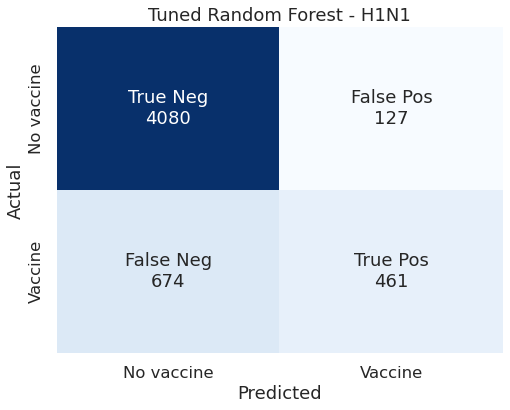

In [57]:
all_metrics(y_test_h1n1, get_predictions('Tuned Random Forest - H1N1')[0], y_score=None, model_name='Tuned Random Forest - H1N1', keep_score=False, save_fig=True, suppress_output=False)

Recall:    0.7442424242424243
Precision: 0.7723270440251573
Accuracy:  0.7798577311868214
F1 score:  0.7580246913580246


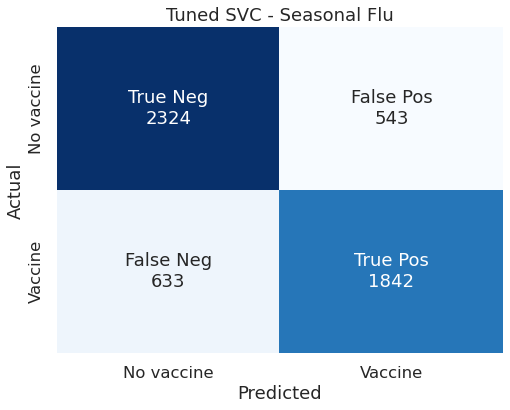

In [59]:
all_metrics(y_test_ssnl, get_predictions('Tuned SVC - SSNL')[0], y_score=None, model_name='Tuned SVC - Seasonal Flu', keep_score=False, save_fig=True, suppress_output=False)